In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import random

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [4]:
from IPython.display import clear_output

In [5]:
# need: pip install git+https://github.com/tensorflow/examples.git
# pip install tensorflow-datasets
# pip install opencv-python

## Data import and process

In [6]:
# Oxford-IIIT Pets dataset which is available from the tensorflow dataset
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)


In [7]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 50

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
train_images = train_images.take(300)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
random.seed(42)
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
# both use the same seed
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [12]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

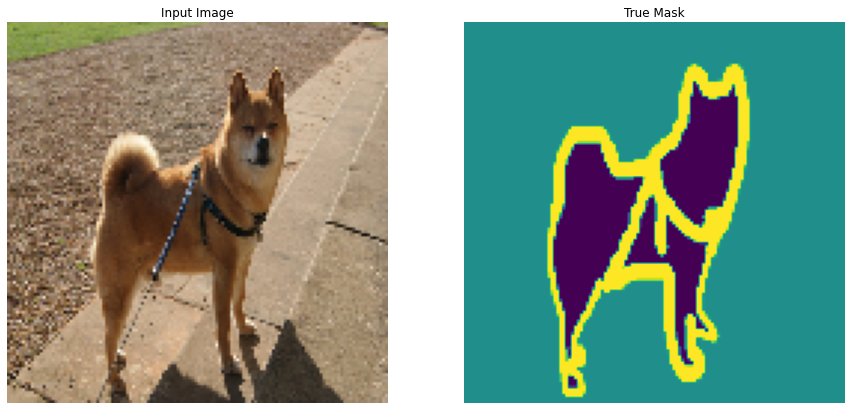

In [32]:
for images, masks in train_batches.take(1):
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])

## Part1: K-means model for image segmentation

In [36]:
#All models are set to train in 12 epoches
#K-means model

In [37]:
proto_tensor = tf.make_tensor_proto(sample_image)  # convert `tensor a` to a proto tensor
img1 = tf.make_ndarray(proto_tensor)    # convert proto tensor to array
img1=np.asarray(img1)

In [38]:
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2RGB)
pixel_values = img1.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)*255

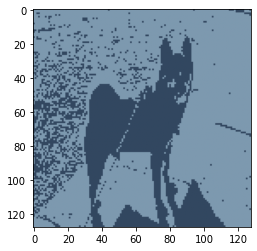

In [39]:
# it is set to meet the criteria either 12 epoches has run or reach the 1 accuracy
# normally it cannot reach 1 so it is halted when 12 epoches has run
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 12  , 1)
 
# then perform k-means clustering wit h number of clusters defined as 2
#also random centres are initially choosed for k-means clustering
# number of clusters (k)
k = 2
_, labels, centers = cv2.kmeans(pixel_values, k, None, criteria, 20, cv2.KMEANS_RANDOM_CENTERS)

# convert data into 8-bit values
centers = np.uint8(centers)

segmented_data = centers[labels.flatten()]

# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((img1.shape))/255.0

plt.imshow(segmented_image)

## Part2: U-net model 

In [41]:
#Encoder
"""
 Convolutional downsampling block

 Arguments:
 inputs -- Input tensor
 n_filters -- Number of filters for the convolutional layers
 dropout_prob -- Dropout probability
 max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of
 Returns:
 next_layer, skip_connection -- Next layer and skip connection outp
"""

def downsampling_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)


 # if dropout_prob > 0 add a dropout layer, with the variable dropout_pr
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)


 # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size= (2,2), padding='valid')(conv)
    else:
        next_layer = conv
    skip_connection = conv

    return next_layer, skip_connection

In [42]:
#Decoder

"""
 Convolutional upsampling block

 Arguments:
 expansive_input -- Input tensor from previous layer
 contractive_input -- Input tensor from previous skip layer
 n_filters -- Number of filters for the convolutional layers
 Returns:
 conv -- Tensor output
"""
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    
    up = tf.keras.layers.Conv2DTranspose(
                n_filters, # number of filters
                3, # Kernel size
                strides=2,
                padding='same')(expansive_input)

 # Merge the previous output and the contractive_input
    merge = tf.keras.layers.concatenate([up, contractive_input], axis=3)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(merge)
    conv = tf.keras.layers.Conv2D(n_filters, # Number of filters
                  3, # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    return conv

In [43]:
"""
 Unet model

 Arguments:
 input_size -- Input shape
 n_filters -- Number of filters for the convolutional layers
 n_classes -- Number of output classes
 Returns:
 model -- tf.keras.Model
"""

def unet_model(input_size=(128, 128, 3), n_filters=32, n_classes=3):

    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
#(encoding)
    cblock1 = downsampling_block(inputs, n_filters)
    cblock2 = downsampling_block(cblock1[0], n_filters*2)
    cblock3 = downsampling_block(cblock2[0], n_filters*4)
    cblock4 = downsampling_block(cblock3[0], n_filters*8, dropout_prob=0.3)
# Include a dropout of 0.3 for this layer, and no max_pooling layer
    cblock5 = downsampling_block(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

#(decoding)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters)
                         
    conv9 = tf.keras.layers.Conv2D(n_filters,
                   3,
                   activation='relu',
                   padding='same',
                   kernel_initializer='he_normal')(ublock9)

    conv10 = tf.keras.layers.Conv2D(n_classes, 1, padding='same')(conv9)

    return tf.keras.Model(inputs=inputs, outputs=conv10)


In [44]:
channels = 3
image_height = 128
image_width = 128

model = unet_model((image_height, image_width, channels))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [46]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])

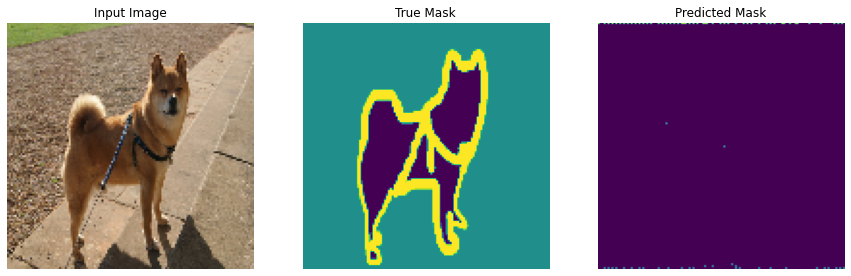

In [47]:
show_predictions()

In [48]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

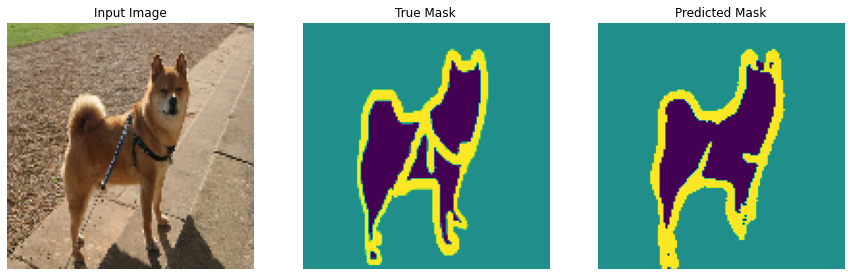


Sample Prediction after epoch 12

50/50 [==============================] - 169s 3s/step - loss: 0.2085 - accuracy: 0.9098 - val_loss: 0.5657 - val_accuracy: 0.8249


In [50]:
EPOCHS = 12
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])